<a href="https://colab.research.google.com/github/americofreitasjr/ModPreditivaAvanc_TrabalhoFinal/blob/master/Case_Waldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabalho de Modelagem Preditiva Avançada - Case WALDATA**
---

## Alunos: **Américo Freitas Junior e Irani Barbosa Junior**

A multinacional de varejo Waldata quer expandir a sua presença na América Latina e por isso decide firmar uma parceria com a FGV para desenvolver um modelo preditivo do
valor de vendas. Além disso a companhia decide investir em uma solução de “Targeted Advertising” que utilizará um modelo de “Machine Learning” para dizer se um cliente irá
aderir ou não ao serviço premium.

---

## Modelos Preditivos para o Valor de Vendas
##### Neste estudo vamos desenvolver e testar modelos de regressão para prever as vendas semanais da Waldata.



### Carregando as Bibliotecas

In [0]:
rm(list = ls())

In [0]:
install.packages("xgboost")
install.packages("e1071")
install.packages("randomForest")
install.packages("mlbench")
install.packages("stringr")
install.packages("dplyr")
install.packages("lubridate")
install.packages("ggplot2")
install.packages("gridExtra")
install.packages("pROC")
install.packages("ROCR")
install.packages("caret")
install.packages("kernlab")

In [0]:
options(warn=-1)
library(caret)
library(pROC)
library(xgboost)
library(e1071)
library(randomForest)
library(mlbench)
library(stringr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gridExtra)
library(ROCR)
library(kernlab)

### Carregando a base de dados Retail.csv



In [0]:
df <- read.csv("Retail.csv", header = TRUE, stringsAsFactors = FALSE)

### Análise Exploratória

In [0]:
head(df)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,1,05/02/2010,42.31,2.572,NA,NA,NA,NA,NA,211.0964,8.106,FALSE,1643690.9
2,1,12/02/2010,38.51,2.548,NA,NA,NA,NA,NA,211.2422,8.106,TRUE,1641957.44
3,1,19/02/2010,39.93,2.514,NA,NA,NA,NA,NA,211.2891,8.106,FALSE,1611968.17
4,1,26/02/2010,46.63,2.561,NA,NA,NA,NA,NA,211.3196,8.106,FALSE,1409727.59
5,1,05/03/2010,46.50,2.625,NA,NA,NA,NA,NA,211.3501,8.106,FALSE,1554806.68
6,1,12/03/2010,57.79,2.667,NA,NA,NA,NA,NA,211.3806,8.106,FALSE,1439541.59


In [0]:
str(df)

'data.frame':	8190 obs. of  13 variables:
 $ Store       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : chr  "05/02/2010" "12/02/2010" "19/02/2010" "26/02/2010" ...
 $ Temperature : num  42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price  : num  2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown2   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown3   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown4   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown5   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ CPI         : num  211 211 211 211 211 ...
 $ Unemployment: num  8.11 8.11 8.11 8.11 8.11 ...
 $ IsHoliday   : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...
 $ Weekly_Sales: chr  "1643690.9" "1641957.44" "1611968.17" "1409727.59" ...


### A base de dados Retail apresenta informações sobre as vendas semanais de 45 lojas com os seguintes campos:

**Store** - Identificação da loja <br>
**Date** - Dia da apuração dos dados <br>
**Temperature** - Temperatura na localidade da loja <br>
**Fuel_Price** - Preço do galão de combustível na localidade <br>
**MarkDown**(n) - Desconto promocional <br>
**Unemployment** - Taxa de desemprego <br>
**IsHoliday** - Se na semana houve feriado <br>
**Weekly_Sales** - Somatório das vendas semanais na loja <br>


In [0]:
summary(df)

     Store        Date            Temperature       Fuel_Price   
 Min.   : 1   Length:8190        Min.   : -7.29   Min.   :2.472  
 1st Qu.:12   Class :character   1st Qu.: 45.90   1st Qu.:3.041  
 Median :23   Mode  :character   Median : 60.71   Median :3.513  
 Mean   :23                      Mean   : 59.36   Mean   :3.406  
 3rd Qu.:34                      3rd Qu.: 73.88   3rd Qu.:3.743  
 Max.   :45                      Max.   :101.95   Max.   :4.468  
                                                                 
   MarkDown1        MarkDown2           MarkDown3           MarkDown4       
 Min.   : -2781   Min.   :  -265.76   Min.   :  -179.26   Min.   :    0.22  
 1st Qu.:  1578   1st Qu.:    68.88   1st Qu.:     6.60   1st Qu.:  304.69  
 Median :  4744   Median :   364.57   Median :    36.26   Median : 1176.42  
 Mean   :  7032   Mean   :  3384.18   Mean   :  1760.10   Mean   : 3292.94  
 3rd Qu.:  8923   3rd Qu.:  2153.35   3rd Qu.:   163.15   3rd Qu.: 3310.01  
 Max.   :1

### Outliers
#####Podemos observar que as variáveis *MarkDown(n)* possuem distribuição assimétrica, dados faltantes, *outliers* e valores negativos. Existe um outlier proeminente na variável MarkDown5.

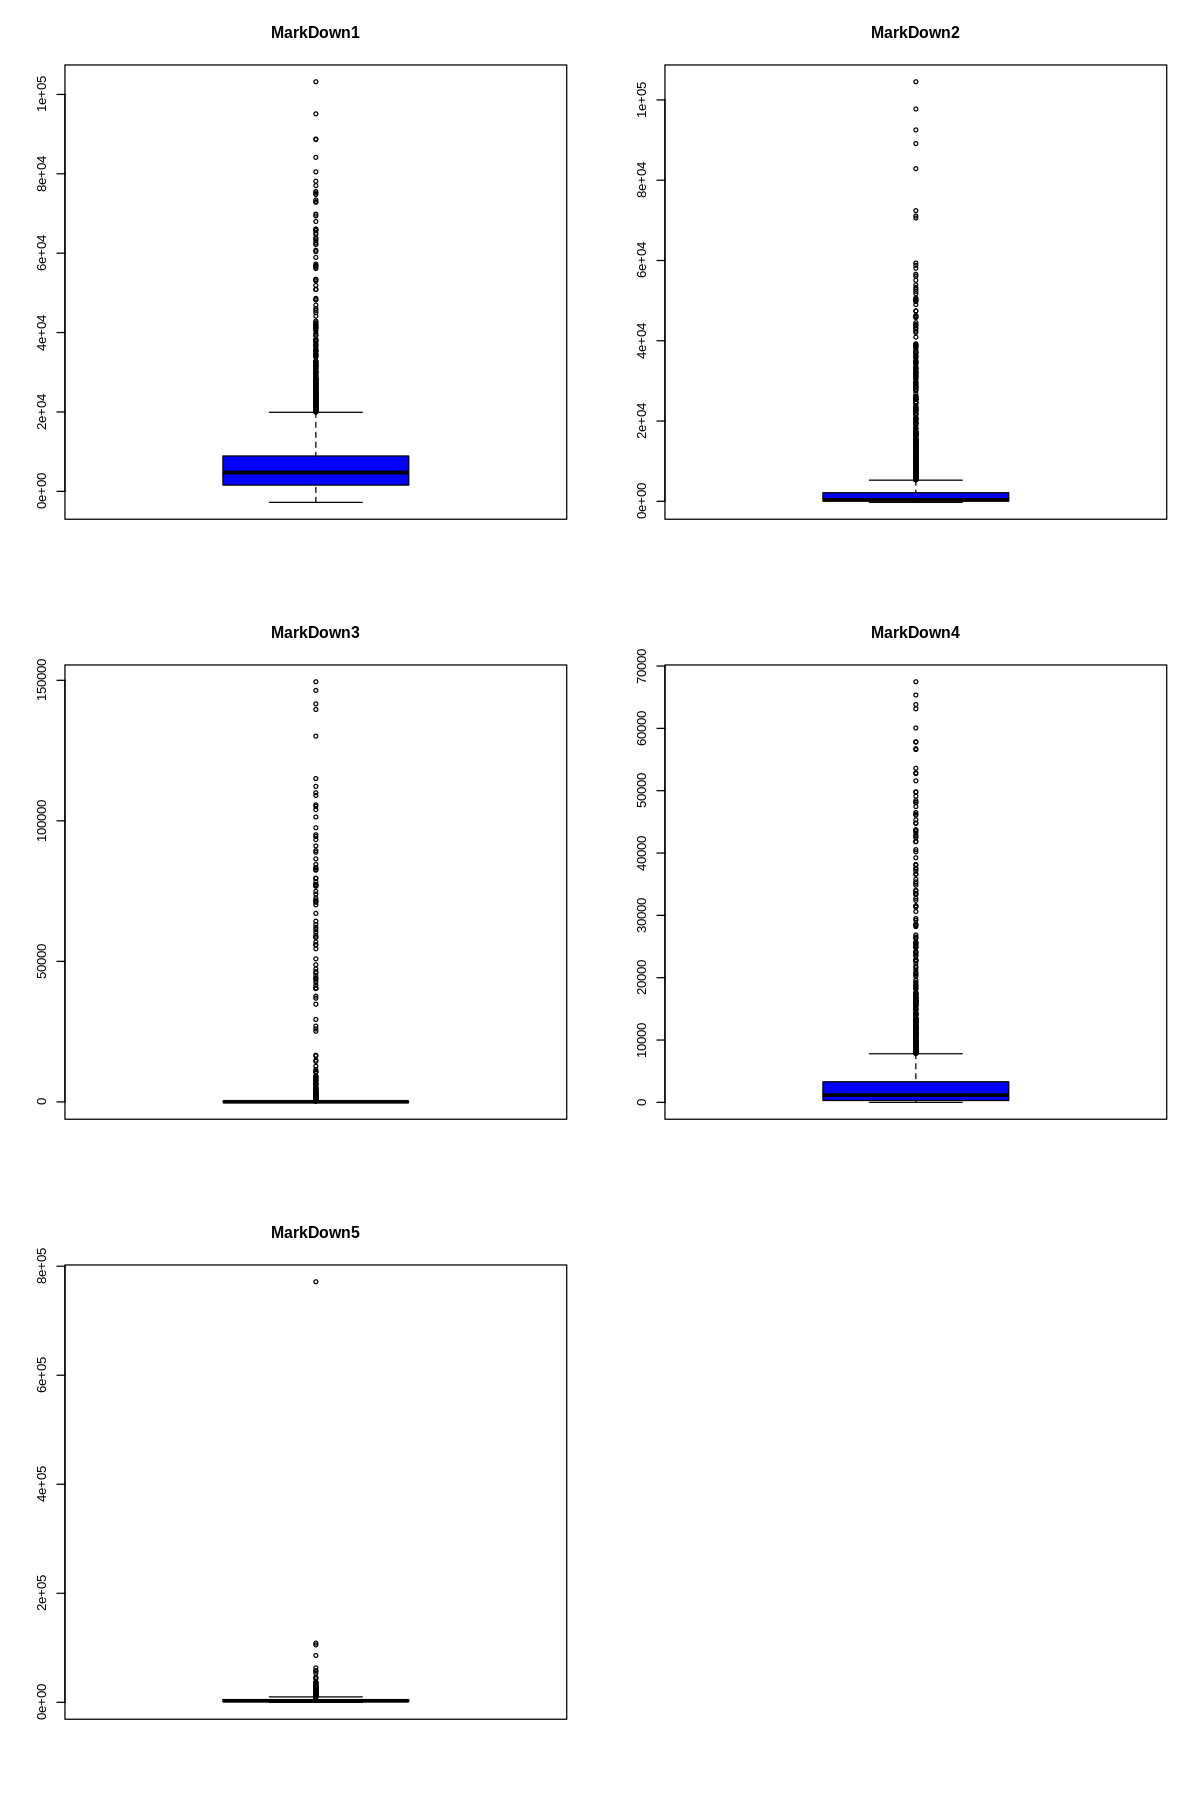

In [0]:
options(repr.plot.width = 10, repr.plot.height = 15)
par(mfrow = c(3, 2))
boxplot(df$MarkDown1, main = "MarkDown1", col = "blue")
boxplot(df$MarkDown2, main = "MarkDown2", col = "blue")
boxplot(df$MarkDown3, main = "MarkDown3", col = "blue")
boxplot(df$MarkDown4, main = "MarkDown4", col = "blue")
boxplot(df$MarkDown5, main = "MarkDown5", col = "blue")
par(mfrow = c(1, 1))

### Valores negativos nas Variáveis MarkDown(n)
##### Existem 44 observações com valor negativo, numero relativamente pequeno se comparado ao tamanho da amostra.

In [0]:
str(df %>% select(MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5) %>%
filter_all (any_vars(. < 0)))

'data.frame':	44 obs. of  5 variables:
 $ MarkDown1: num  8807 1650 1631 9023 5510 ...
 $ MarkDown2: num  -10.5 -11 -35.7 927.3 33063.6 ...
 $ MarkDown3: num  5.99 2.31 15.46 170.24 -0.86 ...
 $ MarkDown4: num  739 1956 327 405 693 ...
 $ MarkDown5: num  4397 1205 2311 -185 3419 ...


### Dados faltantes na variável Weekly_Sales
##### Existem 1755 observações faltantes, valor expressivo comparado ao tamanho da amostra.

In [0]:
str(df %>% select(Weekly_Sales) %>% filter_all(any_vars(. == "#N/D")))

'data.frame':	1755 obs. of  1 variable:
 $ Weekly_Sales: chr  "#N/D" "#N/D" "#N/D" "#N/D" ...


### Tratando os Dados

#####Testamos várias transformações nos dados e simulamos nos modelos buscando a melhor performance geral. O tratamento da base abaixo foi o que apresentou a melhor performance dentro da nossa capacidade computacional. A transformação da variável *Store* em factor, tornou o processamento muito mais pesado mas elevou o R-squared da Regressão Linear de 0.1312 para 0.6678 e afetou positivamente os modelos *Boosting e Rede Neural*, e negativamente o *Bagging e o Random Forest*. Notamos ainda que a escala de importância das variáveis também sofreu grande alteração com a tranformação do *Store* em factor mas apresentou dados coerentes com a realidade conforme veremos a seguir.

##### Entendemos que a a variável Store é uma variável qualitativa de escala nominal e convertemos em tipo Factor.

In [0]:
df$Store <- as.factor(df$Store)

##### Aplicaremos o formato numérico à variável alvo da nossa predição (que foi importada como tipo character).


In [0]:
df$Weekly_Sales <- as.double(df$Weekly_Sales)

##### Consideraremos que os NAs em Weekly_Sales significam que não houveram vendas naquela semana e substituiremos por 0(zero).

In [0]:
df$Weekly_Sales[is.na(df$Weekly_Sales)] <- 0

##### Converteremos a variável **Date** para o formato semana. O novo formato transformará o dado em número da semana, começando do "1" para a primeira semana do ano até o numero "53" que representa a última semana. Optamos por esta transformação para adequar a medida do tempo ao intervalo de apuração das vendas (Weekly_Sales), que é semanal.

In [0]:
df$Date <- as.numeric(str_replace_all(df$Date, fixed("/"), ""))
df$Date <- dmy(df$Date)
df$Date <- week(df$Date)

Consideraremos que os NAs das variáveis *MarkDown(n)* significam que não houve promoção e substituiremos todos por 0.

In [0]:
df$MarkDown1[is.na(df$MarkDown1)] <- 0
df$MarkDown2[is.na(df$MarkDown2)] <- 0
df$MarkDown3[is.na(df$MarkDown3)] <- 0
df$MarkDown4[is.na(df$MarkDown4)] <- 0
df$MarkDown5[is.na(df$MarkDown5)] <- 0

##### Consideraremos que não existe promoção com valores negativos. Como existem apenas 44 observações vamos substituir por zero e considerar que não houve promoção.

In [0]:
df$MarkDown1[df$MarkDown1 < 0] <- 0
df$MarkDown2[df$MarkDown2 < 0] <- 0
df$MarkDown3[df$MarkDown3 < 0] <- 0
df$MarkDown4[df$MarkDown4 < 0] <- 0
df$MarkDown5[df$MarkDown5 < 0] <- 0

##### Excluiremos as informações faltantes (NA)das variáveis CPI e Unemployment pois são apuradas por região e não seria prudente utilizarmos a média entre regiões diferentes, uma vez que não temos os dados da localização geográfica de cada Store. Cogitamos apurar a região dos Stores cruzando os dados da base com os do Governo Americano (que inferimos ser a localização dos Stores), mas devido ao curto prazo para a realização do trabalho, optamos por prosseguir sem esta informação.

In [0]:
df<-df[! is.na(df$CPI),]
df<-df[! is.na(df$Unemployment ),]

##### Excluiremos o outlier mais proeminente que ocorre na variável MarkDown5.

In [0]:
 df<-df[! df$MarkDown5 == 771448.1,]

#### Base Tratada

In [0]:
glimpse(df)

Rows: 7,604
Columns: 13
$ Store        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Date         <dbl> 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …
$ Temperature  <dbl> 42.31, 38.51, 39.93, 46.63, 46.50, 57.79, 54.58, 51.45, …
$ Fuel_Price   <dbl> 2.572, 2.548, 2.514, 2.561, 2.625, 2.667, 2.720, 2.732, …
$ MarkDown1    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MarkDown2    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MarkDown3    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MarkDown4    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MarkDown5    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ CPI          <dbl> 211.0964, 211.2422, 211.2891, 211.3196, 211.3501, 211.38…
$ Unemployment <dbl> 8.106, 8.106, 8.106, 8.106, 8.106, 8.106, 8.106, 8.106, …
$ IsHoliday    <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ Weekly_Sales <dbl> 1643691

In [0]:
summary(df)

     Store           Date        Temperature       Fuel_Price   
 1      : 169   Min.   : 1.00   Min.   : -7.29   Min.   :2.472  
 2      : 169   1st Qu.:12.00   1st Qu.: 44.72   1st Qu.:3.001  
 3      : 169   Median :25.00   Median : 59.25   Median :3.494  
 4      : 169   Mean   :25.59   Mean   : 58.30   Mean   :3.390  
 5      : 169   3rd Qu.:39.00   3rd Qu.: 72.62   3rd Qu.:3.742  
 6      : 169   Max.   :53.00   Max.   :100.14   Max.   :4.468  
 (Other):6590                                                   
   MarkDown1        MarkDown2           MarkDown3           MarkDown4    
 Min.   :     0   Min.   :     0.00   Min.   :     0.00   Min.   :    0  
 1st Qu.:     0   1st Qu.:     0.00   1st Qu.:     0.00   1st Qu.:    0  
 Median :     0   Median :     0.00   Median :     0.00   Median :    0  
 Mean   :  3331   Mean   :  1257.86   Mean   :   822.06   Mean   : 1310  
 3rd Qu.:  4164   3rd Qu.:    42.08   3rd Qu.:    14.61   3rd Qu.:  562  
 Max.   :103185   Max.   :104519.54 

##### A análise do BoxPlot ainda aponta para muitos valores anômalos, que também são produto da transformação dos NAs em 0 (zero), que modificou a posição da mediana e afetou toda a distribuição da variável *MarkDown(n)* Decidimos prosseguir com o estudo sem remover estes *Outliers* até entendermos melhor o quanto o seu comportamento afeta o resultado dos modelos.

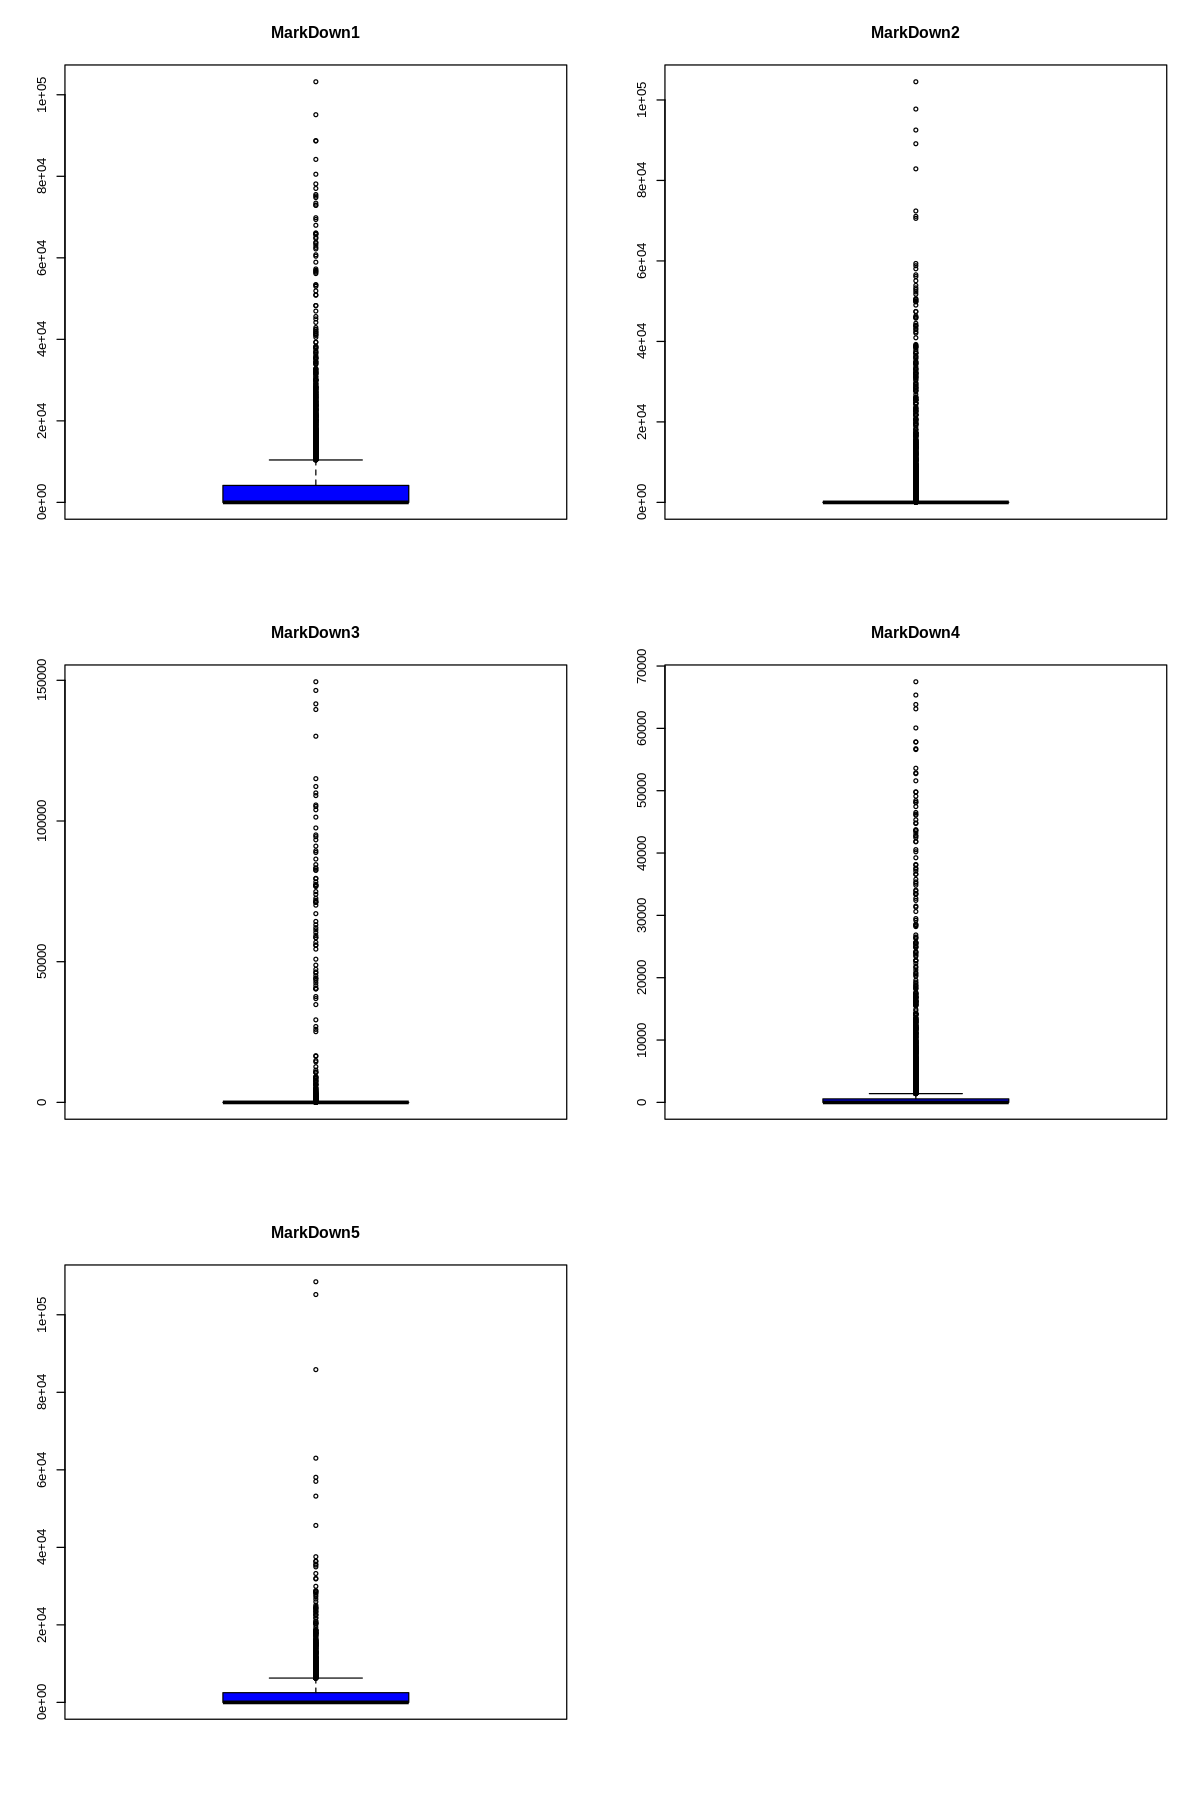

In [0]:
options(repr.plot.width = 10, repr.plot.height = 15)
par(mfrow = c(3, 2))
boxplot(df$MarkDown1, main = "MarkDown1", col = "blue")
boxplot(df$MarkDown2, main = "MarkDown2", col = "blue")
boxplot(df$MarkDown3, main = "MarkDown3", col = "blue")
boxplot(df$MarkDown4, main = "MarkDown4", col = "blue")
boxplot(df$MarkDown5, main = "MarkDown5", col = "blue")
par(mfrow = c(1, 1))

### Modelos para previsão das vendas



### Criando as partições de treino e teste

In [0]:
set.seed(314)
trainIndex <- createDataPartition(df$Weekly_Sales, p = .7, list = FALSE)
df_train <- df[trainIndex,]
df_test <- df[-trainIndex,]

### Modelo de Regressão Linear Múltipla

In [0]:
set.seed(314)
lm <- train(Weekly_Sales ~ ., data = df_train, method = "lm")
lm

Linear Regression 

5324 samples
  12 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 5324, 5324, 5324, 5324, 5324, 5324, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  368543.8  0.6678091  254486.3

Tuning parameter 'intercept' was held constant at a value of TRUE

#### Neste modelo de regressão linear, o R-squared apresentou 0.6678086 um resultado razoável. 

In [0]:
# Score do modelo
lm_pred <- predict(lm, newdata = df_test)

### Modelos de Àrvore de Decisão

#### Utilizaremos os modelos de Boosting, Bagging e Random Forest

### Boosting

In [0]:
# Parametrizando o Cross Validation
set.seed(314)
cv <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE, classProbs=TRUE)

In [0]:
# Treinando Modelo
set.seed(314)
boosting <- train(Weekly_Sales ~ . , data = df_train, method = "xgbTree", trControl = cv)
boosting

eXtreme Gradient Boosting 

5324 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 4792, 4792, 4791, 4792, 4792, 4791, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      466537.6  0.5280045
  0.3  1          0.6               0.50       100      410157.3  0.6164431
  0.3  1          0.6               0.50       150      385774.5  0.6507458
  0.3  1          0.6               0.75        50      468672.5  0.5349220
  0.3  1          0.6               0.75       100      413367.2  0.6199815
  0.3  1          0.6               0.75       150      385895.3  0.6546197
  0.3  1          0.6               1.00        50      470575.1  0.5428449
  0.3  1          0.6               1.00       100      416403.2  0.6251969
  0.3  1          0.6               1.00       150      388294.1  0.6591

#### No modelo Boosting atingimos um R-Squared de 0.9287340.

In [0]:
# Score do Modelo
boosting_pred <- predict(boosting, newdata = df_test)

### Bagging

In [0]:
# Treinando o Modelo
set.seed(314)
bagging <- train(Weekly_Sales ~ . , data = df_train, method = "treebag", trControl = cv)
bagging

Bagged CART 

5324 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 4792, 4792, 4791, 4792, 4792, 4791, ... 
Resampling results:

  RMSE      Rsquared   MAE   
  405634.6  0.6004185  322954


In [0]:
# Score do Modelo
bagging_pred <- predict(bagging, newdata = df_test)

### Random Forest

In [0]:
# Treinando Modelo
set.seed(314)
rf <- train(Weekly_Sales ~ . , data = df_train, method = "rf", trControl = cv)
rf

Random Forest 

5324 samples
  12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 4792, 4792, 4791, 4792, 4792, 4791, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    431904.1  0.7281320  349507.6
  28    210793.4  0.8952530  125272.6
  55    203951.2  0.8997549  114483.6

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 55.

#### Obtivemos um R-Squared de 0.8997549.


In [0]:
# Score do Modelo
rf_pred <- predict(rf, newdata = df_test, type="raw")

### Redes Neurais

In [0]:
# Treinando o Modelo
options(warn=-1)
set.seed(314)
p.grid <- expand.grid(.decay=c(0.5, 0.1), .size=c(10,11,12))
rn <- train(Weekly_Sales ~ ., 
                 data = df_train, 
                 method='nnet', 
                 trace = FALSE,
                 maxit = 1000,
                 skip = TRUE,
                 linout = TRUE,
                 tuneGrid = p.grid)
rn

Neural Network 

5324 samples
  12 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 5324, 5324, 5324, 5324, 5324, 5324, ... 
Resampling results across tuning parameters:

  decay  size  RMSE      Rsquared   MAE     
  0.1    10    369101.7  0.6665851  243748.3
  0.1    11    365666.6  0.6728030  242409.0
  0.1    12    367443.6  0.6697018  242775.0
  0.5    10    373379.6  0.6593782  245118.0
  0.5    11    375846.8  0.6551118  247748.9
  0.5    12    376193.2  0.6548479  248387.0

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were size = 11 and decay = 0.1.

#### Melhor R-Squared foi de 0.6728030.

In [0]:
# Score do Modelo
rn_pred <- predict(rn, newdata = df_test, type = "raw")

## Comparando os Modelos

##### Todos os modelos apresentaram as mesmas variáveis na ordem de importância até o oitavo termo. A ordem de importância se mostrou coerente com a dinâmica do varejo, apresentando variáveis que realmente podem influenciar o volume de vendas e a formação de preços.

In [0]:
imp_lm <- varImp(lm, useModel = FALSE, scale = FALSE)
imp_boosting <- varImp(boosting, useModel = FALSE, scale = FALSE)
imp_bagging <- varImp(bagging, useModel = FALSE, scale = FALSE)
imp_rf <- varImp(rf, useModel = FALSE, scale = FALSE)
imp_rn <- varImp(rn, useModel = FALSE, scale = FALSE)

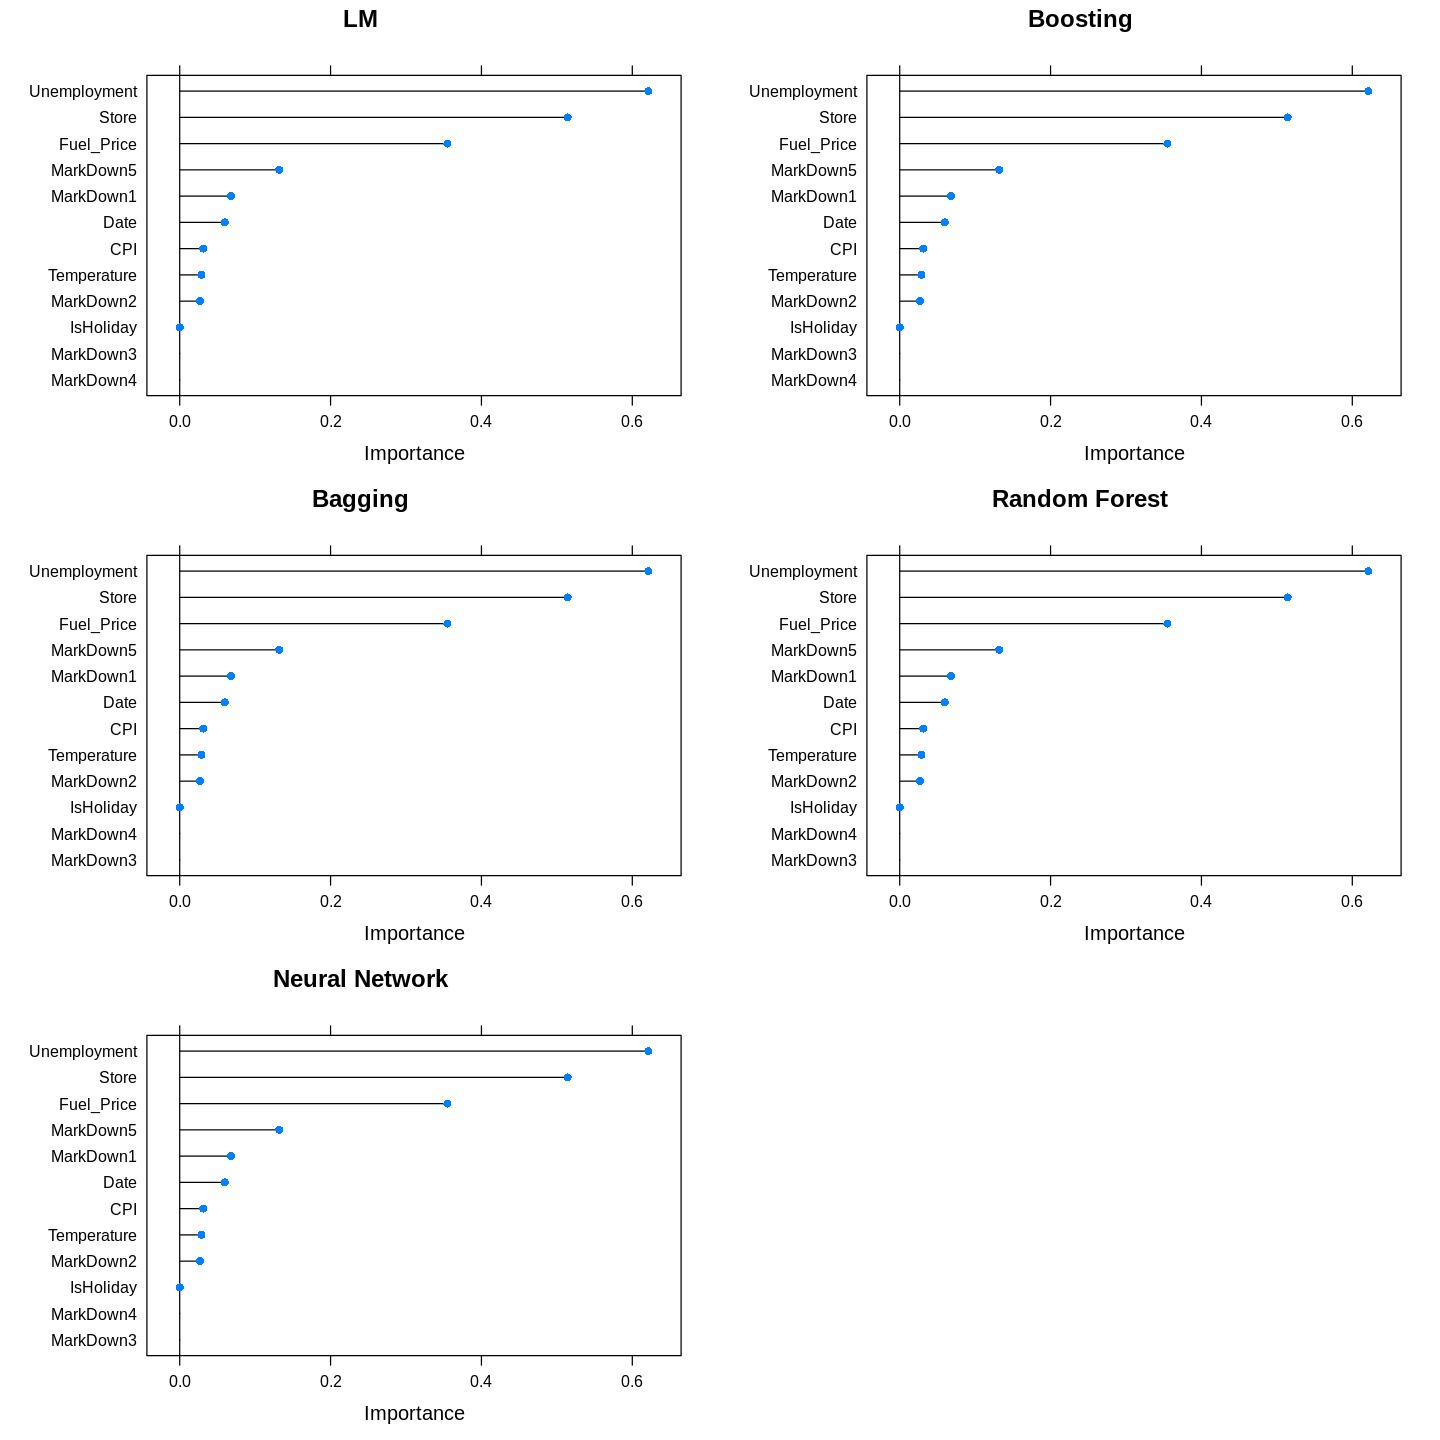

In [0]:
options(repr.plot.width = 12, repr.plot.height = 12)
imp1 <- plot(imp_lm, main = "LM")
imp2 <- plot(imp_boosting, main = "Boosting")
imp3 <- plot(imp_bagging, main = "Bagging")
imp4 <- plot(imp_rf, main = "Random Forest")
imp5<- plot(imp_rn, main = "Neural Network")
grid.arrange(imp1, imp2, imp3, imp4,imp5, ncol = 2)

### Comparativo R-Squared

#####Obtivemos a melhor performance com o modelo Boosting, apresentando R-squared de 0.928734 com o menor tempo de processamento que o Random Forest e a Rede Neural.

In [0]:
r2s <- data.frame("LM" = max(lm$results$Rsquared),
                             "Boosting" = max(boosting$results$Rsquared),
                             "Bagging" = max(bagging$results$Rsquared),
                             "Random_Forest" = max(rf$results$Rsquared),
                             "Rede_Neural" = max(rn$results$Rsquared))
rownames(r2s) <- ("R-Squared")
r2s %>% head() %>% knitr::kable()



|          |        LM| Boosting|   Bagging| Random_Forest| Rede_Neural|
|:---------|---------:|--------:|---------:|-------------:|-----------:|
|R-Squared | 0.6678091| 0.928734| 0.6004185|     0.8997549|    0.672803|

###Considerações sobre os modelos para predição das vendas




##### Neste projeto o maior desafio foi entender e praticar o tratamento adequado à base de dados, preservando a coerência relativa ao negócio e inferindo acerca de informações não disponibilizadas na base. Ao inferirmos que o mix de marketing (preço, produto, praça e promoção) estava implícitamente contido na variável *Store* e transformando a mesma em Factor, conseguimos gerar bons resultados em todos os modelos, com destaque para as Arvores de Decisão *Boosting* e *Random Forest*. A árvore Boosting leva pequena vantagem no R-squared e também apresentou muito menor custo computacional. O risco de Overfitting devido ao alto valor do R-squared apresentado pela *boosting* foi minimizado com a utilização do Cross Validation.

---
---

## Modelos Targeted Advertising

##### Testaremos modelos de Regressão Logística, Árvores de Decisão, SVM e Redes Neurais 

### Análise Exploratória

### Lendo a Base de Dados

#####Para a aquisição dos dados, utilizaremos o read.csv2 que já considera o separador ";".

In [0]:
df2 <- read.csv2("Marketing.csv", header = TRUE)

In [0]:
head(df2)

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1_1,93.994,-36_4,no
2,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1_1,93.994,-36_4,no
3,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1_1,93.994,-36_4,no
4,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1_1,93.994,-36_4,no
5,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1_1,93.994,-36_4,no
6,45,services,married,basic_9y,unknown,no,no,telephone,may,mon,198,1,-1,0,nonexistent,1_1,93.994,-36_4,no


In [0]:
glimpse(df2)

Rows: 41,188
Columns: 19
$ AGE            <int> 56, 57, 37, 40, 56, 45, 59, 41, 24, 25, 41, 25, 29, 57…
$ JOB            <fct> housemaid, services, services, admin, services, servic…
$ MARITAL_STATUS <fct> married, married, married, married, married, married, …
$ EDUCATION      <fct> basic_4y, high_school, high_school, basic_6y, high_sch…
$ DEFAULT        <fct> no, unknown, no, no, no, unknown, no, unknown, no, no,…
$ HOUSING        <fct> no, no, yes, no, no, no, no, no, yes, yes, no, yes, no…
$ LOAN           <fct> no, no, no, no, yes, no, no, no, no, no, no, no, yes, …
$ CONTACT        <fct> telephone, telephone, telephone, telephone, telephone,…
$ MONTH          <fct> may, may, may, may, may, may, may, may, may, may, may,…
$ DAY_OF_WEEK    <fct> mon, mon, mon, mon, mon, mon, mon, mon, mon, mon, mon,…
$ DURATION       <int> 261, 149, 226, 151, 307, 198, 139, 217, 380, 50, 55, 2…
$ CAMPAIGN       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ PDAYS          <int> -1, 

### A base de dados Marketing.csv possui as seguintes variáveis:
* AGE	- Idade
*JOB -	Profissão
*MARITAL_STATUS - Estado civil
*EDUCATION - Educação
*DEFAULT	- Contas Atrasadas ?
*HOUSING	- Hipoteca ?
*LOAN	- Empréstimo Pessoal ?
*CONTACT - Tipo de Contato
*MONTH - Último Mês de Contato
*DAY_OF_WEEK - Último Dia da Semana de Contato
*DURATION - Duração do Último Contato em segundos
*CAMPAIGN	- Tipo de Campanha de Marketing
*PDAYS - Número de Dias desde Último Contato (-1: Não Houve Contato)
*PREVIOUS - Número de Contatos Antes da Campanha
*POUTCOME - Resultado da Última Campanha
*EMP_VAR_RATE - Taxa de Desemprego da Região
*CONS_PRICE_IDX - IGPM
*CONS_CONF_IDX - Índice de Confiança do Consumidor
*SUBSCRIBED - Aderiu ao Serviço ?




##### A base de dados possui 41188 registros. É uma quantidade muito grande para nossa capacidade computacional em modelos de classificação. Utilizaremos uma amostra de aproximadamente 10% para o nosso estudo.

In [0]:
df2 <- sample_n(df2, 4000, replace=F)

In [0]:
summary(df2)

      AGE                 JOB        MARITAL_STATUS               EDUCATION   
 Min.   :17.00   admin      :1046   divorced: 422   university_degree  :1198  
 1st Qu.:32.00   blue-collar: 884   married :2395   high_school        : 936  
 Median :38.00   technician : 683   single  :1173   basic_9y           : 588  
 Mean   :40.03   services   : 353   unknown :  10   professional_course: 510  
 3rd Qu.:47.00   management : 283                   basic_4y           : 394  
 Max.   :88.00   retired    : 168                   basic_6y           : 204  
                 (Other)    : 583                   (Other)            : 170  
    DEFAULT        HOUSING          LOAN           CONTACT         MONTH     
 no     :3135   no     :1788   no     :3280   cellular :2501   may    :1354  
 unknown: 865   unknown: 119   unknown: 119   telephone:1499   jul    : 686  
 yes    :   0   yes    :2093   yes    : 601                    aug    : 611  
                                                        

##### Transformaremos a variavel df2$CONS_CONF_IDX para o tipo numeric:

In [0]:
df2$CONS_CONF_IDX <- as.numeric(str_replace_all(df2$CONS_CONF_IDX, fixed("_"), "."))
str(df2$CONS_CONF_IDX)

 num [1:4000] -47.1 -42 -41.8 -42 -42.7 -36.4 -42 -37.5 -36.1 -31.4 ...


##### Transformaremos a variavel df2$CONS_PRICE_IDX para o tipo numeric:

In [0]:
df2$CONS_PRICE_IDX <- as.character(df2$CONS_PRICE_IDX)
df2$CONS_PRICE_IDX <- as.numeric(df2$CONS_PRICE_IDX)
str(df2$CONS_PRICE_IDX)

 num [1:4000] 93.1 NA 94.5 NA 93.9 ...


##### Transformaremos a variavel df2$EMP_VAR_RATE para o tipo numeric:

In [0]:
df2$EMP_VAR_RATE <- as.numeric(str_replace_all(df2$EMP_VAR_RATE, fixed("_"), "."))
str(df2$EMP_VAR_RATE)

 num [1:4000] -1.8 -0.1 1.4 -0.1 1.4 1.1 -0.1 -1.1 1.4 -2.9 ...


In [0]:
summary(df2$EMP_VAR_RATE)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.40000 -1.80000  1.10000  0.08189  1.40000  1.40000 

In [0]:
set.seed(314)
trainIndex <- createDataPartition(df2$SUBSCRIBED, p = .7, list = FALSE)
df2_train <- df2[trainIndex,]
df2_test <- df2[-trainIndex,]

### Parametrizando o Cross Validation

In [0]:
set.seed(314)
cv <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE,
summaryFunction = twoClassSummary, classProbs=TRUE)

### Modelo de Regressão Logistica

In [0]:
df2_glm <- train(SUBSCRIBED ~ ., data = df2_train, method = "glm", metric ="ROC", trControl = cv, 
                   control = list(maxit = 50))

In [0]:
df2_glm

Generalized Linear Model 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2521, 2520, 2520, 2519, 2520, ... 
Resampling results:

  ROC        Sens       Spec     
  0.9164076  0.9703904  0.4288172


In [0]:
#Score do Modelo
df2_glm_pred <- predict(df2_glm, newdata = df2_test)

In [0]:
# Curva ROC
df2_glm_pred_prob <- predict(df2_glm, newdata = df2_test, type="prob")
glm_roc <- roc(predictor = df2_glm_pred_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



In [0]:
# Matriz de Confusão
cm_glm <- confusionMatrix(data = df2_glm_pred, df2_test$SUBSCRIBED, positive = "yes")
cm_glm
cm_glm_Sensitivity <- data.frame(cm_glm$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1030   78
       yes   41   51
                                          
               Accuracy : 0.9008          
                 95% CI : (0.8825, 0.9172)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.1886611       
                                          
                  Kappa : 0.4086          
                                          
 Mcnemar's Test P-Value : 0.0009665       
                                          
            Sensitivity : 0.39535         
            Specificity : 0.96172         
         Pos Pred Value : 0.55435         
         Neg Pred Value : 0.92960         
             Prevalence : 0.10750         
         Detection Rate : 0.04250         
   Detection Prevalence : 0.07667         
      Balanced Accuracy : 0.67853         
                                          
       'Positive' Class : yes             
                        

### Modelo Árvore de Decisão

#### Boosting

In [0]:
# Treinando o Modelo
df2_boosting <- train(SUBSCRIBED ~ . , data = df2_train, method = "xgbTree", trControl = cv)
df2_boosting

eXtreme Gradient Boosting 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2520, 2520, 2520, 2520, 2520, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  ROC        Sens     
  0.3  1          0.6               0.50        50      0.9144533  0.9731904
  0.3  1          0.6               0.50       100      0.9170493  0.9707871
  0.3  1          0.6               0.50       150      0.9171441  0.9671839
  0.3  1          0.6               0.75        50      0.9176156  0.9815936
  0.3  1          0.6               0.75       100      0.9200481  0.9723888
  0.3  1          0.6               0.75       150      0.9206382  0.9683839
  0.3  1          0.6               1.00        50      0.9153698  0.9823936
  0.3  1          0.6               1.00       100      0.9205943  0.9731888
  0.3  1          0.6               

In [0]:
# Score do Modelo
df2_boosting_pred <- predict(df2_boosting, newdata = df2_test)

In [0]:
# Matriz de Confusão
cm_boosting <- confusionMatrix(df2_boosting_pred, df2_test$SUBSCRIBED, positive = "yes")
cm_boosting
cm_boosting_Sensitivity <- data.frame(cm_boosting$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1044   85
       yes   27   44
                                          
               Accuracy : 0.9067          
                 95% CI : (0.8888, 0.9225)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.05988         
                                          
                  Kappa : 0.3937          
                                          
 Mcnemar's Test P-Value : 7.205e-08       
                                          
            Sensitivity : 0.34109         
            Specificity : 0.97479         
         Pos Pred Value : 0.61972         
         Neg Pred Value : 0.92471         
             Prevalence : 0.10750         
         Detection Rate : 0.03667         
   Detection Prevalence : 0.05917         
      Balanced Accuracy : 0.65794         
                                          
       'Positive' Class : yes             
                        

In [0]:
# Curva ROC
df2_boosting_pred_prob <- predict(df2_boosting, newdata = df2_test, type="prob")
boosting_roc <- roc(predictor = df2_boosting_pred_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



#### Bagging

In [0]:
# Treinando o Modelo
df2_bagging <- train(SUBSCRIBED ~ ., data = df2_train, method = "treebag", trControl = cv)
df2_bagging

Bagged CART 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2520, 2520, 2520, 2520, 2520, ... 
Resampling results:

  ROC        Sens       Spec     
  0.8926375  0.9579823  0.4290323


In [0]:
# Score do Modelo
df2_bagging_pred <- predict(df2_bagging, newdata = df2_test)

In [0]:
# Curva ROC
df2_bagging_pred_prob <- predict(df2_bagging, newdata = df2_test, type="prob")
bagging_roc <- roc(predictor = df2_bagging_pred_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



In [0]:
# Matriz de Confusão
cm_bagging <- confusionMatrix(df2_bagging_pred, df2_test$SUBSCRIBED,  positive = "yes")
cm_bagging
cm_bagging_Sensitivity <- data.frame(cm_bagging$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1026   71
       yes   45   58
                                          
               Accuracy : 0.9033          
                 95% CI : (0.8852, 0.9195)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.12105         
                                          
                  Kappa : 0.4472          
                                          
 Mcnemar's Test P-Value : 0.02028         
                                          
            Sensitivity : 0.44961         
            Specificity : 0.95798         
         Pos Pred Value : 0.56311         
         Neg Pred Value : 0.93528         
             Prevalence : 0.10750         
         Detection Rate : 0.04833         
   Detection Prevalence : 0.08583         
      Balanced Accuracy : 0.70380         
                                          
       'Positive' Class : yes             
                        

#### Random Forest

In [0]:
# Treinando o Modelo
df2_rf <- train(SUBSCRIBED ~ . , data = df2_train, method = "rf", trControl = cv)
df2_rf

Random Forest 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2519, 2520, 2520, 2520, 2521, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec      
    2   0.8966921  0.9972000  0.04655914
   54   0.9098064  0.9619775  0.40881720
  107   0.9047901  0.9571743  0.40870968

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 54.

In [0]:
# Score do Modelo
df2_rf_pred <- predict(df2_rf, newdata = df2_test)

In [0]:
# Matriz de confusão
cm_rf <- confusionMatrix(df2_rf_pred, df2_test$SUBSCRIBED,  positive = "yes")
cm_rf
cm_rf_Sensitivity <- data.frame(cm_rf$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1031   82
       yes   40   47
                                          
               Accuracy : 0.8983          
                 95% CI : (0.8798, 0.9149)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.2749155       
                                          
                  Kappa : 0.3816          
                                          
 Mcnemar's Test P-Value : 0.0002057       
                                          
            Sensitivity : 0.36434         
            Specificity : 0.96265         
         Pos Pred Value : 0.54023         
         Neg Pred Value : 0.92633         
             Prevalence : 0.10750         
         Detection Rate : 0.03917         
   Detection Prevalence : 0.07250         
      Balanced Accuracy : 0.66350         
                                          
       'Positive' Class : yes             
                        

In [0]:
# Curva ROC
df2_rf_pred_prob <- predict(df2_rf, newdata = df2_test, type="prob")
rf_roc <- roc(predictor = df2_rf_pred_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



### Support Vector Machine (SVM)

#### Linear Kernel

In [0]:
#Parametrizando o Cross Validation
set.seed(314)
cv_svm <- trainControl(method = "repeatedcv", number = 10, classProbs = TRUE)

In [0]:
# Treinando o Modelo
options(warn=-1)
df2_svm_lk <- train(SUBSCRIBED ~ ., data = df2_train,  
                       method = "svmLinear", trControl = cv_svm, 
                       preProcess = c("center", "scale"))
df2_svm_lk

Support Vector Machines with Linear Kernel 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

Pre-processing: centered (107), scaled (107) 
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2521, 2520, 2520, 2519, 2520, ... 
Resampling results:

  Accuracy   Kappa   
  0.9060788  0.349451

Tuning parameter 'C' was held constant at a value of 1

In [0]:
# Score do Modelo
df2_svm_lk_pred <- predict(df2_svm_lk, newdata=df2_test)

In [0]:
# Matriz de confusão
cm_svm_lk <- confusionMatrix(df2_svm_lk_pred, df2_test$SUBSCRIBED,  positive = "yes")
cm_svm_lk
cm_svm_lk_Sensitivity <- data.frame(cm_svm_lk$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1046  100
       yes   25   29
                                          
               Accuracy : 0.8958          
                 95% CI : (0.8772, 0.9125)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.3763          
                                          
                  Kappa : 0.2707          
                                          
 Mcnemar's Test P-Value : 3.622e-11       
                                          
            Sensitivity : 0.22481         
            Specificity : 0.97666         
         Pos Pred Value : 0.53704         
         Neg Pred Value : 0.91274         
             Prevalence : 0.10750         
         Detection Rate : 0.02417         
   Detection Prevalence : 0.04500         
      Balanced Accuracy : 0.60073         
                                          
       'Positive' Class : yes             
                        

In [0]:
# Curva ROC
df2_svm_lk_prob <- predict(df2_svm_lk, newdata = df2_test, type="prob")

df2_svm_lk_roc <- roc(predictor = df2_svm_lk_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



#### RFB Kernel

In [0]:
# Treinando o modelo
options=(warn=-1)
df2_rfb <- train(SUBSCRIBED ~ .,data=df2_train,
                 method="svmRadial",
                 trControl=cv_svm,
                preProcess= c("center", "scale"),
                metric="ROC")
df2_rfb

Support Vector Machines with Radial Basis Function Kernel 

2800 samples
  18 predictor
   2 classes: 'no', 'yes' 

Pre-processing: centered (107), scaled (107) 
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2520, 2520, 2520, 2521, 2520, 2520, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.8953607  0.2543426
  0.50  0.8964283  0.2563359
  1.00  0.8996464  0.2869211

Tuning parameter 'sigma' was held constant at a value of 0.007493442
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.007493442 and C = 1.

In [0]:
# Score do modelo
df2_rfb_pred <- predict(df2_rfb, newdata = df2_test)

In [0]:
# Matriz de confusão
cm_rfb <- confusionMatrix(df2_rfb_pred, df2_test$SUBSCRIBED,  positive = "yes")
cm_rfb
cm_rfb_Sensitivity <- data.frame(cm_rfb$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  1046  111
       yes   25   18
                                          
               Accuracy : 0.8867          
                 95% CI : (0.8674, 0.9041)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.7597          
                                          
                  Kappa : 0.1644          
                                          
 Mcnemar's Test P-Value : 3.13e-13        
                                          
            Sensitivity : 0.13953         
            Specificity : 0.97666         
         Pos Pred Value : 0.41860         
         Neg Pred Value : 0.90406         
             Prevalence : 0.10750         
         Detection Rate : 0.01500         
   Detection Prevalence : 0.03583         
      Balanced Accuracy : 0.55810         
                                          
       'Positive' Class : yes             
                        

In [0]:
# Curva ROC
df2_rfb_prob <- predict(df2_rfb, newdata = df2_test, type="prob")

df2_rfb_roc <- roc(predictor = df2_rfb_prob$yes,
               response = df2_test$SUBSCRIBED,
               levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



### Rede Neural

In [0]:
# Treinando o Modelo
df2_rn <- train(SUBSCRIBED ~.,
                data=df2_train,
               method="nnet",
               trace=FALSE,
               preProc=c("center", "scale"))

In [0]:
df2_rn

Neural Network 

28832 samples
   18 predictor
    2 classes: 'no', 'yes' 

Pre-processing: centered (107), scaled (107) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 28832, 28832, 28832, 28832, 28832, 28832, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa     
  1     0e+00  0.8882216  0.05815921
  1     1e-04  0.8874344  0.03559486
  1     1e-01  0.8895193  0.16109851
  3     0e+00  0.8993048  0.47582406
  3     1e-04  0.8948198  0.45229743
  3     1e-01  0.9009146  0.50685079
  5     0e+00  0.9042368  0.49691834
  5     1e-04  0.9030612  0.48529012
  5     1e-01  0.9062205  0.50448069

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were size = 5 and decay = 0.1.

In [0]:
# Score do Modelo
df2_rn_pred <- predict(df2_rn, newdata=df2_test)

In [0]:
# Matriz de Confusão
cm_rn <- confusionMatrix(df2_rn_pred, df2_test$SUBSCRIBED,  positive = "yes")
cm_rn
cm_rn_Sensitivity <- data.frame(cm_rn$byClass)[1, ]

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  983  58
       yes  88  71
                                          
               Accuracy : 0.8783          
                 95% CI : (0.8585, 0.8963)
    No Information Rate : 0.8925          
    P-Value [Acc > NIR] : 0.94654         
                                          
                  Kappa : 0.4248          
                                          
 Mcnemar's Test P-Value : 0.01639         
                                          
            Sensitivity : 0.55039         
            Specificity : 0.91783         
         Pos Pred Value : 0.44654         
         Neg Pred Value : 0.94428         
             Prevalence : 0.10750         
         Detection Rate : 0.05917         
   Detection Prevalence : 0.13250         
      Balanced Accuracy : 0.73411         
                                          
       'Positive' Class : yes             
                              

In [0]:
# Curva ROC
df2_rn_prob <- predict(df2_rn, newdata = df2_test , type = "prob")
df2_rn_prob_roc <- roc(predictor = df2_rn_prob$yes,
                       response = df2_test$SUBSCRIBED,
                       levels = rev(levels(df2_test$SUBSCRIBED)))

Setting direction: controls > cases



## Comparando os modelos

##### Importância das variáveis

In [0]:
imp_glm <- varImp(df2_glm, useModel = FALSE, scale = FALSE)
imp_bst2 <- varImp(df2_boosting, useModel = FALSE, scale = FALSE)
imp_bag2 <- varImp(df2_bagging, useModel = FALSE, scale = FALSE)
imp_rf2 <- varImp(df2_rf, useModel = FALSE, scale = FALSE)
imp_svm_lin <- varImp(df2_svm_lk, useModel = FALSE, scale = FALSE)
imp_svm_rad <- varImp(df2_rfb, useModel = FALSE, scale = FALSE)
imp_rn2 <- varImp(df2_rn, useModel = FALSE, scale = FALSE)

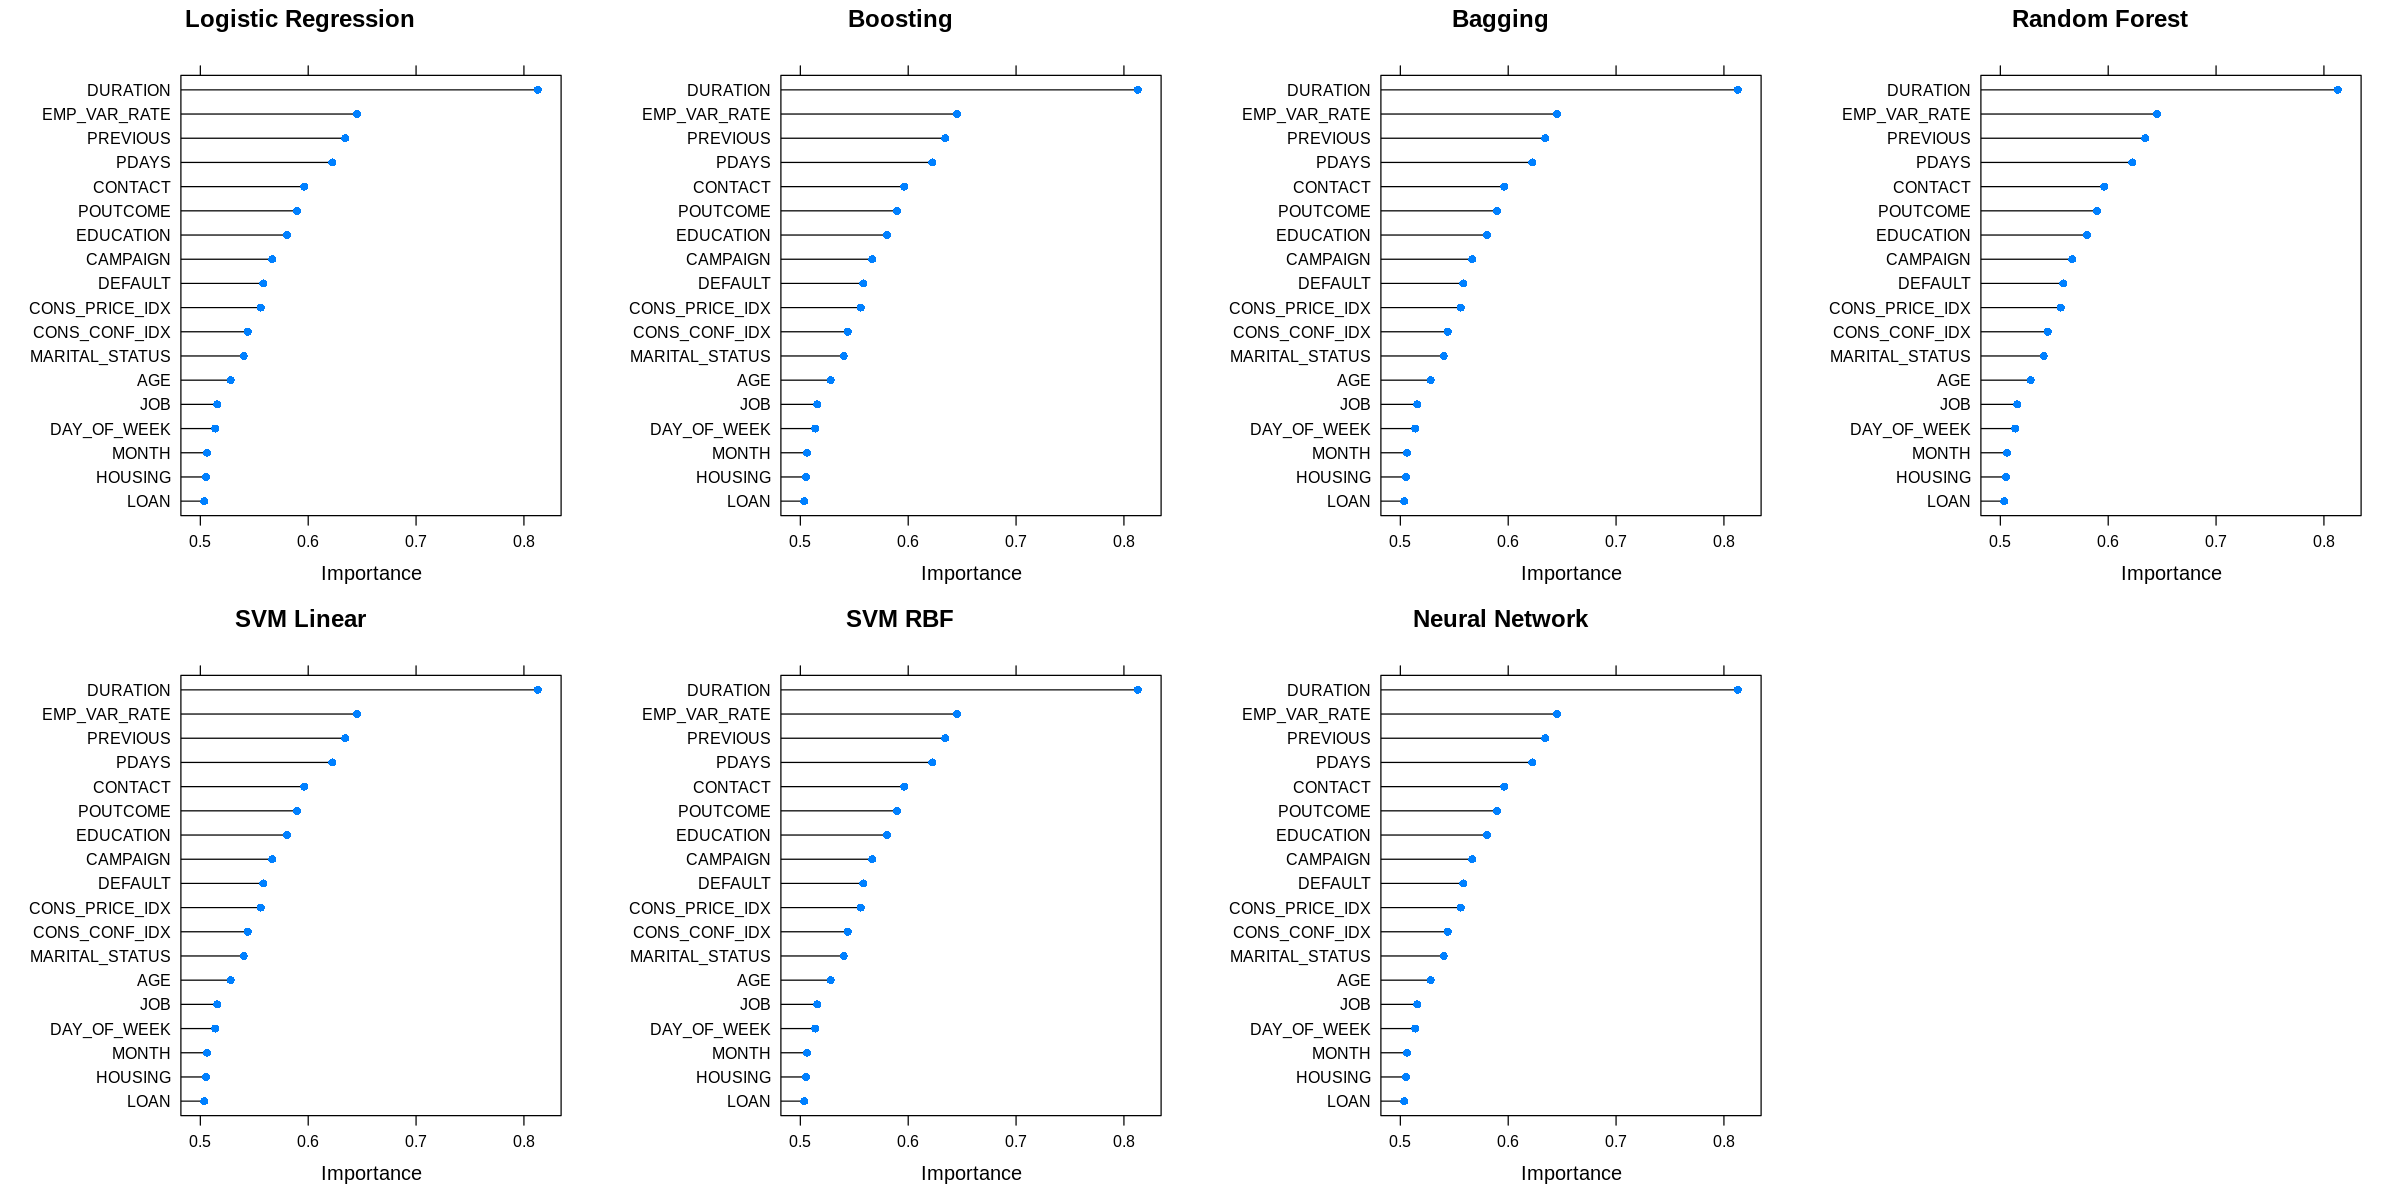

In [0]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,7))
pl1 <- plot(imp_glm, main = "Logistic Regression")
pl2 <- plot(imp_bst2, main = "Boosting")
pl3 <- plot(imp_bag2, main = "Bagging")
pl4 <- plot(imp_rf2, main = "Random Forest")
pl5 <- plot(imp_svm_lin, main = "SVM Linear")
pl6 <- plot(imp_svm_rad, main = "SVM RBF")
pl7 <- plot(imp_rn2, main = "Neural Network")
grid.arrange(pl1, pl2, pl3, pl4, pl5, pl6, pl7, ncol = 4)
par(mfrow = c(1,1))

#####Os modelos de classificação testados apresentaram a mesma escala de importância para as variáveis preditoras, com destaque para as variáveis que envolvem o relacionamento interpessoal (meio de contato, duração do contato e se houve contato prévio) demonstrando ser o contato pessoal um importante fator para a adesão ao Serviço Premium. A ordem de importância das variáveis também apresenta coerência com os aspectos do negócio.

##### Curva ROC

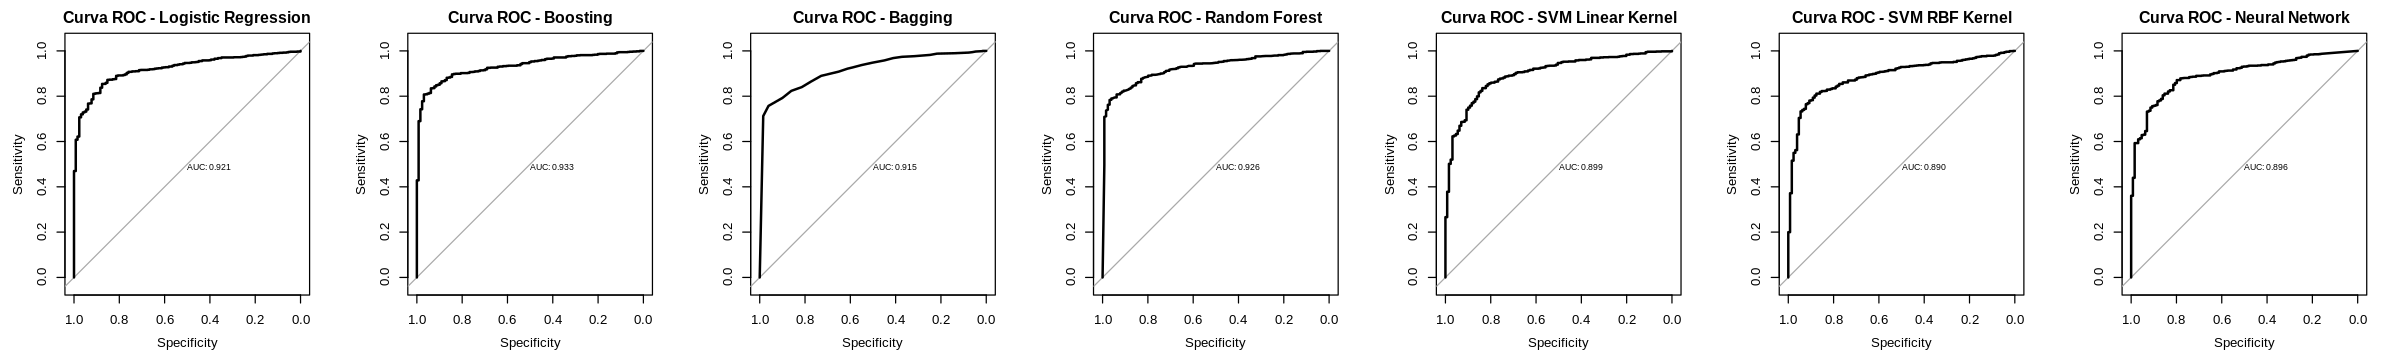

In [0]:
options(repr.plot.width = 20, repr.plot.height = 3)
par(mfrow = c(1,7))
plot(glm_roc, main="Curva ROC - Logistic Regression", print.auc = TRUE)
plot(boosting_roc, main="Curva ROC - Boosting", print.auc = TRUE)
plot(bagging_roc, main="Curva ROC - Bagging", print.auc = TRUE)
plot(rf_roc, main="Curva ROC - Random Forest", print.auc = TRUE)
plot(df2_svm_lk_roc, main="Curva ROC - SVM Linear Kernel", print.auc = TRUE)
plot(df2_rfb_roc, main="Curva ROC - SVM RBF Kernel", print.auc = TRUE)
plot(df2_rn_prob_roc, main="Curva ROC - Neural Network", print.auc = TRUE)
par(mfrow = c(1,1))

##### AUC

In [0]:
md_auc <- data.frame("Logistic Regression" = max(glm_roc$auc),
                             "Boosting" = max(boosting_roc$auc),
                             "Bagging" = max(bagging_roc$auc),
                             "Random Forest" = max(rf_roc$auc),
                             "SVM Linear" = max(df2_svm_lk_roc$auc),
                             "SVM RFB"= max(df2_rfb_roc$auc),
                             "Rede Neural" = max(df2_rn_prob_roc$auc))
rownames(md_auc) <- ("AUC")
md_auc %>% head() %>% knitr::kable()



|    | Logistic.Regression|  Boosting|   Bagging| Random.Forest| SVM.Linear|   SVM.RFB| Rede.Neural|
|:---|-------------------:|---------:|---------:|-------------:|----------:|---------:|-----------:|
|AUC |           0.9209389| 0.9334101| 0.9150182|     0.9260852|  0.8992538| 0.8897792|   0.8960184|

#####Todos os modelos performaram AUC acima de 0.9 com destaque mais uma vez para o modelo de Árvore de Decisão Boosting com os seus impressionantes 0.9429437 (acurácia de 0.9149). O grande numero de observações da base de dados e a utilização do Cross Validation nos deixou confiantes no resultado e minimizou o risco de Overfitting apesar do alto valor dos indicadores de performance.

In [0]:
models_Sensitivity <- data.frame("Logistic Regression" = cm_glm_Sensitivity, "Boosting" = cm_boosting_Sensitivity,
"Bagging" = cm_bagging_Sensitivity, "Random Forest" = cm_rf_Sensitivity, "SVM Linear" = cm_svm_lk_Sensitivity, 
"SVM RFB" = cm_rfb_Sensitivity, "Rede Neural" = cm_rn_Sensitivity)
rownames(models_Sensitivity) <- ("SENSITIVIDADE")
models_Sensitivity %>% head() %>% knitr::kable()



|              | Logistic.Regression|  Boosting|   Bagging| Random.Forest| SVM.Linear|   SVM.RFB| Rede.Neural|
|:-------------|-------------------:|---------:|---------:|-------------:|----------:|---------:|-----------:|
|SENSITIVIDADE |           0.3953488| 0.3410853| 0.4496124|     0.3643411|  0.2248062| 0.1395349|   0.5503876|

### Considerações sobre os modelos para Targeted Advertising

##### Nesta modelagem, a ótima qualidade da base de dados facilitou o nosso trabalho. O desafio aqui foi o custo computacional dos modelos. Desde o início, utilizamos o notebook baseado em Jupyter do Google Colab Pro, devido a possibilidade de desenvolvermos o trabalho conjuntamente e em tempo real. Esta decisão se mostrou acertada quando configuramos o notebook para utilizar a GPU Nvidia e a memória expandida do Colab. Isto possibilitou que aplicássemos os algorítimos de classificação em toda a base de dados, de tamanho considerável e com muitas variáveis factor. Poderíamos optar por executar os algorítimos localmente com uma pequena amostra da base, mas acreditamos que os excelentes resultados que alcançamos se devem à qualidade e a quantidade de observações da base utilizada integralmente. Ainda assim, com todo o poder computacional do Google Colab Pro, a conclusão de todos os modelos de classificação levou 14 horas consecutivas.

In [0]:
set.seed(314)
training <- twoClassSim(n = 1000, intercept = -16)
testing <- twoClassSim(n = 1000, intercept = -16)

In [0]:
table(training$Class)


Class1 Class2 
   919     81 

In [0]:
mod0 <- train(Class ~ ., data = training,
               method = "rf",
               metric = "ROC",
               tuneGrid = data.frame(mtry = 3),
               trControl = trainControl(method = "cv",
                                        classProbs = TRUE,
                                        summaryFunction = twoClassSummary))

In [0]:
getTrainPerf(mod0)

TrainROC,TrainSens,TrainSpec,method
<dbl>,<dbl>,<dbl>,<chr>
0.9143702,0.998913,0.2944444,rf


In [0]:
fourStats <- function (data, lev = levels(data$obs), model = NULL) {
  ## This code will get use the area under the ROC curve and the
  ## sensitivity and specificity values using the current candidate
  ## value of the probability threshold.
  out <- c(twoClassSummary(data, lev = levels(data$obs), model = NULL))
 
  ## The best possible model has sensitivity of 1 and specifity of 1. 
  ## How far are we from that value?
  coords <- matrix(c(1, 1, out["Spec"], out["Sens"]), 
                   ncol = 2, 
                   byrow = TRUE)
  colnames(coords) <- c("Spec", "Sens")
  rownames(coords) <- c("Best", "Current")
  c(out, Dist = dist(coords)[1])
}

In [0]:
set.seed(314)
mod1 <- train(Class ~ ., data = training,
              ## 'modelInfo' is a list object found in the linked
              ## source code
              method = modelInfo,
              ## Minimize the distance to the perfect model
              metric = "Dist",
              maximize = FALSE,
              tuneLength = 20,
              trControl = trainControl(method = "cv",
                                       classProbs = TRUE,
                                       summaryFunction = fourStats))

ERROR: ignored